## Feature Engineering

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression

def df_split(train_df, test_size, result_col='radiant_win', seed = 70):
      X = train_df.drop(columns=result_col)
      y = train_df[result_col]

      seed = seed
      X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=seed)

      return X_train, X_val,y_train, y_val

def lane_dominance_features(df):
    for i in range(1,6):
        r_prefix = f'r{i}_'
        d_prefix = f'd{i}_'

        #Last hit efficiency
        df[f'r{i}_lane_control'] = df[r_prefix + 'lh'] / (df[d_prefix + 'denies'] + 1)
        df[f'd{i}_lane_control'] = df[d_prefix + 'lh'] / (df[r_prefix + 'denies'] + 1)

        #Gold per minute
        minutes = df['game_time'].clip(lower=60) / 60
        df[f'r{i}_gold_per_min'] = df[r_prefix + 'gold'] / minutes
        df[f'd{i}_gold_per_min'] = df[d_prefix + 'gold'] / minutes

        #KDA (Kill denied)
        df[f'r{i}_kda'] = (df[r_prefix + 'kills'] + df[r_prefix + 'assists']) / (df[r_prefix + 'deaths'] + 1)
        df[f'd{i}_kda'] = (df[d_prefix + 'kills'] + df[d_prefix + 'assists']) / (df[d_prefix + 'deaths'] + 1)

    return df


def team_stats(df):
    r1_cols = [col for col in df.columns if col.startswith('r1_')]
    player_stats = [col.replace('r1_', '') for col in r1_cols]
    non_incl_stats = ['hero_id', 'x', 'y']
    player_stats_col = [x for x in player_stats if x not in non_incl_stats]

    r_players = [f'r{i}' for i in range(1, 6)]
    d_players = [f'd{i}' for i in range(1, 6)]

    new_features = {}

    for stat in player_stats_col:
        r_stat_cols = [f'{p}_{stat}' for p in r_players]
        d_stat_cols = [f'{p}_{stat}' for p in d_players]

        r_sum = df[r_stat_cols].sum(axis=1)
        d_sum = df[d_stat_cols].sum(axis=1)
        #r_max = df[r_stat_cols].max(axis=1)
        #d_max = df[d_stat_cols].max(axis=1)

        new_features[f'r_{stat}_sum'] = r_sum
        #new_features[f'r_{stat}_max'] = r_max
        new_features[f'd_{stat}_sum'] = d_sum
        #new_features[f'd_{stat}_max'] = d_max

    df = pd.concat([df, pd.DataFrame(new_features)], axis=1)
    df = pd.get_dummies(df, columns=['game_mode', 'lobby_type'], dtype=int)

    drop_col = (
        ['ID'] +
        [col for col in df.columns
         if any(col.startswith(x) for x in (r_players + d_players))]
    )
    df.drop(columns=drop_col, inplace=True)

    return df


def team_win_rates(df):
    r_cols = [f"r{i}_hero_id" for i in range(1, 6)]
    d_cols = [f"d{i}_hero_id" for i in range(1, 6)]
    all_hero_cols = r_cols + d_cols

    # total appearances of each hero
    all_heroes = pd.concat([data[col] for col in all_hero_cols])
    hero_appearances = all_heroes.value_counts().sort_index()

    r_win_heroes = data[data['radiant_win'] == True][r_cols]
    r_win_heroes_flat = pd.concat([r_win_heroes[col] for col in r_cols])

    d_win_heroes = data[data['radiant_win'] == False][d_cols]
    d_win_heroes_flat = pd.concat([d_win_heroes[col] for col in d_cols])

    hero_wins = pd.concat([r_win_heroes_flat, d_win_heroes_flat]).value_counts().sort_index()

    hero_win_rate = pd.DataFrame({
        'wins': hero_wins,
        'appearances': hero_appearances
    }).fillna(0)
    hero_win_rate.index.name = 'hero_id'

    # win rate
    hero_win_rate['win_rate'] = hero_win_rate['wins'] / hero_win_rate['appearances']

    def get_win_rate(row, team_cols):
        hero_ids = row[team_cols].values
        win_rates = hero_win_rate.loc[hero_ids, 'win_rate'].values
        return win_rates.sum()

    df = df.copy()
    df['r_winrate'] = df.apply(lambda row: get_win_rate(row, r_cols), axis=1)
    df['d_winrate'] = df.apply(lambda row: get_win_rate(row, d_cols), axis=1)

    return df


def team_position(df):
    r_x_cols = [f"r{i}_x" for i in range(1, 6)]
    r_y_cols = [f"r{i}_y" for i in range(1, 6)]
    d_x_cols = [f"d{i}_x" for i in range(1, 6)]
    d_y_cols = [f"d{i}_y" for i in range(1, 6)]
    '''
    # team centroid
    df['r_centroid_x'] = df[r_x_cols].mean(axis=1)
    df['r_centroid_y'] = df[r_y_cols].mean(axis=1)
    df['d_centroid_x'] = df[d_x_cols].mean(axis=1)
    df['d_centroid_y'] = df[d_y_cols].mean(axis=1)

    # team spread
    df['r_spread'] = df.apply(lambda row: np.sqrt(
        np.mean([(row[f"r{i}_x"] - row['r_centroid_x'])**2 + (row[f"r{i}_y"] - row['r_centroid_y'])**2 for i in range(1, 6)])
    ), axis=1)

    df['d_spread'] = df.apply(lambda row: np.sqrt(
        np.mean([(row[f"d{i}_x"] - row['d_centroid_x'])**2 + (row[f"d{i}_y"] - row['d_centroid_y'])**2 for i in range(1, 6)])
    ), axis=1)'''

    # count of players pushing past mid-line
    df['r_aggression_count'] = df[r_x_cols].gt(128).sum(axis=1)
    df['d_aggression_count'] = df[d_x_cols].lt(128).sum(axis=1)

    return df


def hero_presence_dummies(df):
    df = df.copy()

    radiant_hero_cols = [f"r{i}_hero_id" for i in range(1, 6)]
    dire_hero_cols = [f"d{i}_hero_id" for i in range(1, 6)]

    radiant_dummies = pd.get_dummies(df[radiant_hero_cols].stack(), prefix='radiant_hero').groupby(level=0).max()
    dire_dummies = pd.get_dummies(df[dire_hero_cols].stack(), prefix='dire_hero').groupby(level=0).max()

    df = pd.concat([df, radiant_dummies, dire_dummies], axis=1)

    #df.drop(columns=radiant_hero_cols + dire_hero_cols, inplace=True)

    return df


synergy_model = None
synergy_feature_cols = None

def train_synergy_model(df):
    global synergy_model, synergy_feature_cols

    r_cols = [f"r{i}_hero_id" for i in range(1, 6)]
    d_cols = [f"d{i}_hero_id" for i in range(1, 6)]

    radiant = df[df['radiant_win'] == 1][r_cols]
    dire = df[df['radiant_win'] == 0][d_cols]
    radiant.columns = dire.columns = [f"hero{i}" for i in range(1, 6)]
    radiant['win'] = 1
    dire['win'] = 1
    win_df = pd.concat([radiant, dire])

    radiant = df[df['radiant_win'] == 0][r_cols]
    dire = df[df['radiant_win'] == 1][d_cols]
    radiant.columns = dire.columns = [f"hero{i}" for i in range(1, 6)]
    radiant['win'] = 0
    dire['win'] = 0
    lose_df = pd.concat([radiant, dire])

    hero_df = pd.concat([win_df, lose_df])

    team_heroes = hero_df[[f"hero{i}" for i in range(1, 6)]].values.tolist()
    dummy_df = pd.get_dummies(pd.DataFrame(team_heroes).stack().astype(int))
    dummy_df = dummy_df.groupby(level=0).sum()
    dummy_df.columns = [f"hero_{col}" for col in dummy_df.columns]
    dummy_df['win'] = hero_df['win'].values

    X = dummy_df.drop(columns='win')
    y = dummy_df['win']
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)

    synergy_model = model
    synergy_feature_cols = X.columns

def compute_team_synergy(hero_ids):
    dummy = pd.Series(0, index=synergy_feature_cols, dtype=int)
    for h in hero_ids:
        col = f"hero_{int(h)}"
        if col in dummy:
            dummy[col] = 1
    return synergy_model.predict_proba(dummy.to_frame().T)[0, 1]

def team_synergies(df):
    if synergy_model is None:
        raise ValueError("Synergy model not trained. Call `train_synergy_model(train_df)` first.")

    r_cols = [f"r{i}_hero_id" for i in range(1, 6)]
    d_cols = [f"d{i}_hero_id" for i in range(1, 6)]

    df = df.copy()
    df['r_synergy'] = df[r_cols].apply(lambda row: compute_team_synergy(row.values), axis=1)
    df['d_synergy'] = df[d_cols].apply(lambda row: compute_team_synergy(row.values), axis=1)
    df['net_synergy'] = df['r_synergy'] - df['d_synergy']
    return df

def net_stats(df):
    net_cols = {
        f'net_{col[2:]}': df[col] - df[f'd_{col[2:]}' ]
        for col in df.columns if col.startswith('r_') and f'd_{col[2:]}' in df.columns
    }

    df = df.assign(**net_cols)
    df.drop(columns=[col for col in df.columns if col.startswith(('r_', 'd_'))], inplace=True)

    return df


def feature_engineering(df):
    return (
        df.pipe(hero_presence_dummies)
          .pipe(team_synergies)
          .pipe(lane_dominance_features)
          .pipe(team_position)
          .pipe(team_stats)
          .pipe(net_stats)
    )

#### Process: Feature Analysis

**Inspect the Player Locations**

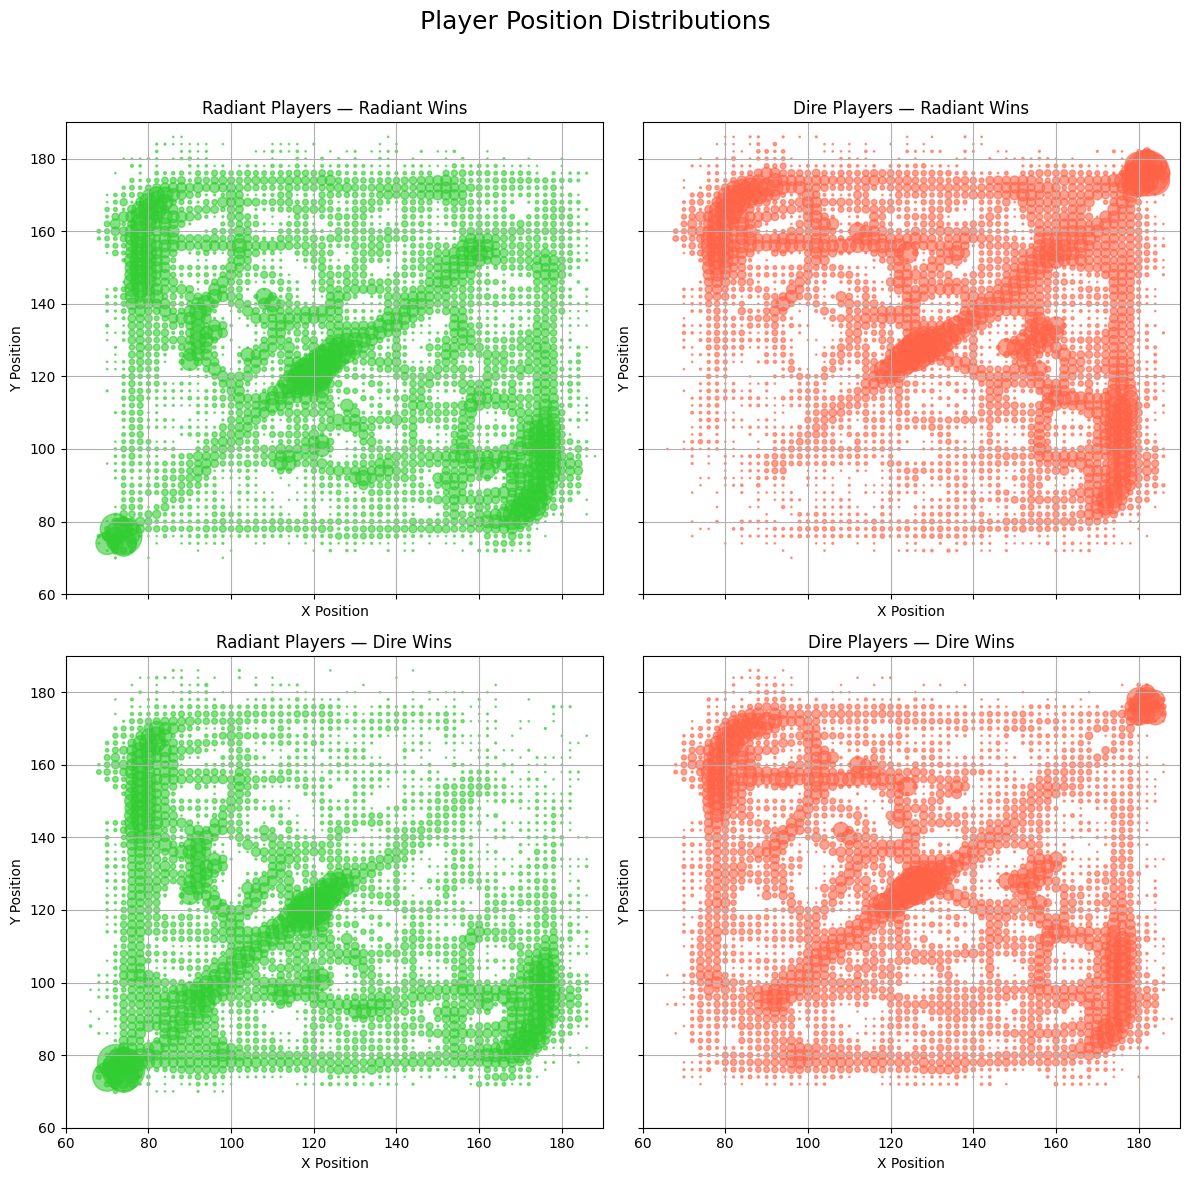

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def get_position_counts(x_vals, y_vals):
    coords = list(zip(x_vals, y_vals))
    df_counts = pd.Series(coords).value_counts().reset_index()
    df_counts.columns = ['coords', 'count']
    df_counts['x'] = df_counts['coords'].apply(lambda t: t[0])
    df_counts['y'] = df_counts['coords'].apply(lambda t: t[1])
    return df_counts

# Segment the match outcomes
radiant_win_df = data[data['radiant_win'] == 1]
dire_win_df = data[data['radiant_win'] == 0]

# Player coordinates
r_x_cols = [f"r{i}_x" for i in range(1, 6)]
r_y_cols = [f"r{i}_y" for i in range(1, 6)]
d_x_cols = [f"d{i}_x" for i in range(1, 6)]
d_y_cols = [f"d{i}_y" for i in range(1, 6)]

# Get position counts
r_win_r = get_position_counts(radiant_win_df[r_x_cols].values.flatten(), radiant_win_df[r_y_cols].values.flatten())
r_win_d = get_position_counts(radiant_win_df[d_x_cols].values.flatten(), radiant_win_df[d_y_cols].values.flatten())
d_win_r = get_position_counts(dire_win_df[r_x_cols].values.flatten(), dire_win_df[r_y_cols].values.flatten())
d_win_d = get_position_counts(dire_win_df[d_x_cols].values.flatten(), dire_win_df[d_y_cols].values.flatten())

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

axes[0, 0].scatter(r_win_r['x'], r_win_r['y'], s=r_win_r['count'], c='limegreen', alpha=0.6)
axes[0, 0].set_title("Radiant Players — Radiant Wins")

axes[0, 1].scatter(r_win_d['x'], r_win_d['y'], s=r_win_d['count'], c='tomato', alpha=0.6)
axes[0, 1].set_title("Dire Players — Radiant Wins")

axes[1, 0].scatter(d_win_r['x'], d_win_r['y'], s=d_win_r['count'], c='limegreen', alpha=0.6)
axes[1, 0].set_title("Radiant Players — Dire Wins")

axes[1, 1].scatter(d_win_d['x'], d_win_d['y'], s=d_win_d['count'], c='tomato', alpha=0.6)
axes[1, 1].set_title("Dire Players — Dire Wins")

# Common axis formatting
for ax in axes.flatten():
    ax.set_xlim(60, 190)
    ax.set_ylim(60, 190)
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.grid(True)

plt.suptitle("Player Position Distributions", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

For games that a team wins, they tend to have more player locations that passes the mid-line

## Load data

In [2]:
data = pd.read_csv('train_data.csv')
train_synergy_model(data)

df = feature_engineering(data)

In [126]:
pd.set_option('display.max_columns', None)
df

,game_time,objectives_len,chat_len,radiant_win,radiant_hero_1,radiant_hero_2,radiant_hero_3,radiant_hero_4,radiant_hero_5,radiant_hero_6,radiant_hero_7,radiant_hero_8,radiant_hero_9,radiant_hero_10,radiant_hero_11,radiant_hero_12,radiant_hero_13,radiant_hero_14,radiant_hero_15,radiant_hero_16,radiant_hero_17,radiant_hero_18,radiant_hero_19,radiant_hero_20,radiant_hero_21,radiant_hero_22,radiant_hero_23,radiant_hero_25,radiant_hero_26,radiant_hero_27,radiant_hero_28,radiant_hero_29,radiant_hero_30,radiant_hero_31,radiant_hero_32,radiant_hero_33,radiant_hero_34,radiant_hero_35,radiant_hero_36,radiant_hero_37,radiant_hero_38,radiant_hero_39,radiant_hero_40,radiant_hero_41,radiant_hero_42,radiant_hero_43,radiant_hero_44,radiant_hero_45,radiant_hero_46,radiant_hero_47,radiant_hero_48,radiant_hero_49,radiant_hero_50,radiant_hero_51,radiant_hero_52,radiant_hero_53,radiant_hero_54,radiant_hero_55,radiant_hero_56,radiant_hero_57,radiant_hero_58,radiant_hero_59,radiant_hero_60,radiant_hero_61,radiant_hero_62,radiant_hero_63,radiant_hero_64,radiant_hero_65,radiant_hero_66,radiant_hero_67,radiant_hero_68,radiant_hero_69,radiant_hero_70,radiant_hero_71,radiant_hero_72,radiant_hero_73,radiant_hero_74,radiant_hero_75,radiant_hero_76,radiant_hero_77,radiant_hero_78,radiant_hero_79,radiant_hero_80,radiant_hero_81,radiant_hero_82,radiant_hero_83,radiant_hero_84,radiant_hero_85,radiant_hero_86,radiant_hero_87,radiant_hero_88,radiant_hero_89,radiant_hero_90,radiant_hero_91,radiant_hero_92,radiant_hero_93,radiant_hero_94,radiant_hero_95,radiant_hero_96,radiant_hero_97,radiant_hero_98,radiant_hero_99,radiant_hero_100,radiant_hero_101,radiant_hero_102,radiant_hero_103,radiant_hero_104,radiant_hero_105,radiant_hero_106,radiant_hero_107,radiant_hero_108,radiant_hero_109,radiant_hero_110,radiant_hero_111,radiant_hero_112,radiant_hero_113,radiant_hero_114,radiant_hero_119,radiant_hero_120,dire_hero_1,dire_hero_2,dire_hero_3,dire_hero_4,dire_hero_5,dire_hero_6,dire_hero_7,dire_hero_8,dire_hero_9,dire_hero_10,dire_hero_11,dire_hero_12,dire_hero_13,dire_hero_14,dire_hero_15,dire_hero_16,dire_hero_17,dire_hero_18,dire_hero_19,dire_hero_20,dire_hero_21,dire_hero_22,dire_hero_23,dire_hero_25,dire_hero_26,dire_hero_27,dire_hero_28,dire_hero_29,dire_hero_30,dire_hero_31,dire_hero_32,dire_hero_33,dire_hero_34,dire_hero_35,dire_hero_36,dire_hero_37,dire_hero_38,dire_hero_39,dire_hero_40,dire_hero_41,dire_hero_42,dire_hero_43,dire_hero_44,dire_hero_45,dire_hero_46,dire_hero_47,dire_hero_48,dire_hero_49,dire_hero_50,dire_hero_51,dire_hero_52,dire_hero_53,dire_hero_54,dire_hero_55,dire_hero_56,dire_hero_57,dire_hero_58,dire_hero_59,dire_hero_60,dire_hero_61,dire_hero_62,dire_hero_63,dire_hero_64,dire_hero_65,dire_hero_66,dire_hero_67,dire_hero_68,dire_hero_69,dire_hero_70,dire_hero_71,dire_hero_72,dire_hero_73,dire_hero_74,dire_hero_75,dire_hero_76,dire_hero_77,dire_hero_78,dire_hero_79,dire_hero_80,dire_hero_81,dire_hero_82,dire_hero_83,dire_hero_84,dire_hero_85,dire_hero_86,dire_hero_87,dire_hero_88,dire_hero_89,dire_hero_90,dire_hero_91,dire_hero_92,dire_hero_93,dire_hero_94,dire_hero_95,dire_hero_96,dire_hero_97,dire_hero_98,dire_hero_99,dire_hero_100,dire_hero_101,dire_hero_102,dire_hero_103,dire_hero_104,dire_hero_105,dire_hero_106,dire_hero_107,dire_hero_108,dire_hero_109,dire_hero_110,dire_hero_111,dire_hero_112,dire_hero_113,dire_hero_114,dire_hero_119,dire_hero_120,net_synergy,game_mode_2,game_mode_3,game_mode_4,game_mode_5,game_mode_12,game_mode_16,game_mode_22,game_mode_23,lobby_type_0,lobby_type_7,net_aggression_count,net_kills_sum,net_deaths_sum,net_assists_sum,net_denies_sum,net_gold_sum,net_lh_sum,net_xp_sum,net_health_sum,net_max_health_sum,net_max_mana_sum,net_level_sum,net_stuns_sum,net_creeps_stacked_sum,net_camps_stacked_sum,net_rune_pickups_sum,net_firstblood_claimed_sum,net_teamfight_participation_sum,net_towers_killed_sum,net_roshans_killed_sum,net_obs_placed_sum,net_sen_placed_sum,net_lane_control_sum,net_gold_per_min_sum,net_kda_sum
0,871,4

## Model

In [132]:
!pip install keras_tuner

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from keras_tuner.tuners import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from lightgbm import LGBMClassifier

#### Hyperparameter Tuning

In [53]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    for i in range(hp.Int('num_layers', 3, 11)):
        model.add(Dense(units=hp.Choice(f'units_{i}', [128, 256, 512]),
                        activation=None))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', 0.0, 0.4, step=0.05)))

    model.add(Dense(1, activation='sigmoid'))

    learning_rate = hp.Choice('lr',[0.0001, 0.0005, 0.001, 0.005, 0.01])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    return model


tuner = BayesianOptimization(
    build_model,
    objective='val_auc',
    max_trials=50,
    executions_per_trial=1,
    directory='dota2_keras',
    project_name='bayesian_tuning'
)

early_stop = EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)

tuner.search(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1,
    batch_size=64
)

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:")
print(f"Learning rate: {best_hp.get('lr')}")
print(f"Number of layers: {best_hp.get('num_layers')}")
for i in range(best_hp.get('num_layers')):
    print(f"Layer {i+1}: units={best_hp.get(f'units_{i}')}, dropout={best_hp.get(f'dropout_{i}')}")

Trial 50 Complete [00h 07m 05s]
val_auc: 0.8203800916671753

Best val_auc So Far: 0.823483943939209
Total elapsed time: 04h 05m 02s
Best hyperparameters:
Learning rate: 0.0005
Number of layers: 9
Layer 1: units=256, dropout=0.4
Layer 2: units=256, dropout=0.25
Layer 3: units=512, dropout=0.0
Layer 4: units=128, dropout=0.1
Layer 5: units=256, dropout=0.4
Layer 6: units=256, dropout=0.4
Layer 7: units=256, dropout=0.25
Layer 8: units=128, dropout=0.05
Layer 9: units=256, dropout=0.15000000000000002


### Ensemble Model

In [128]:
X_train, X_val, y_train, y_val = df_split(df, 0.3)

In [133]:
# NN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

nn_model = Sequential([
    Input(shape=(X_train.shape[1],)),

    Dense(256), BatchNormalization(), Activation('relu'), Dropout(0.4),
    Dense(256), BatchNormalization(), Activation('relu'), Dropout(0.25),
    Dense(512), BatchNormalization(), Activation('relu'), Dropout(0.0),
    Dense(128), BatchNormalization(), Activation('relu'), Dropout(0.1),
    Dense(256), BatchNormalization(), Activation('relu'), Dropout(0.4),
    Dense(256), BatchNormalization(), Activation('relu'), Dropout(0.4),
    Dense(256), BatchNormalization(), Activation('relu'), Dropout(0.25),
    Dense(128), BatchNormalization(), Activation('relu'), Dropout(0.0),
    Dense(256), BatchNormalization(), Activation('relu'), Dropout(0.15),

    Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

earlystop = EarlyStopping(monitor='val_auc', patience=20, mode='max', restore_best_weights=True)

history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[earlystop],
    verbose=1
)

Epoch 1/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.6344 - auc: 0.7011 - loss: 0.6252 - val_accuracy: 0.7258 - val_auc: 0.8223 - val_loss: 0.5189
Epoch 2/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7092 - auc: 0.7962 - loss: 0.5386 - val_accuracy: 0.7294 - val_auc: 0.8225 - val_loss: 0.5178
Epoch 3/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7150 - auc: 0.7971 - loss: 0.5436 - val_accuracy: 0.7329 - val_auc: 0.8227 - val_loss: 0.5120
Epoch 4/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7184 - auc: 0.8045 - loss: 0.5295 - val_accuracy: 0.7318 - val_auc: 0.8227 - val_loss: 0.5104
Epoch 5/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.7215 - auc: 0.8076 - loss: 0.5285 - val_accuracy: 0.7322 - val_auc: 0.8231 - val_loss: 0.5104
Epoch 6/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.7194 - auc: 0.8070 - loss: 0.5280 - val_accuracy: 0.7324 - val_auc: 0.8232 - val_loss: 0.5118
Epoch 7/100
325/325 ━━━━

In [134]:
gbm_model = LGBMClassifier(
        objective='binary',
        metric='binary_error',
        learning_rate=0.05,
        num_leaves=31,
        n_estimators=1000,
        random_state=42,
        verbose = -1)

gbm_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(50)]
    )

y_probs = gbm_model.predict_proba(X_val)[:, 1]

gbm_auc = roc_auc_score(y_val, y_probs)

print(f'ROC AUC: {gbm_auc:.4f}')

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	valid_0's auc: 0.846667	valid_0's binary_error: 0.238908
ROC AUC: 0.8467


In [135]:
# LightGBM
y_pred_lgb = gbm_model.predict_proba(X_val)[:, 1]

# Neural Network
y_pred_nn = nn_model.predict(X_val).flatten()

X_stack = np.vstack([y_pred_lgb, y_pred_nn]).T

meta_model = LogisticRegression()
meta_model.fit(X_stack, y_val)

ensemble_probs = meta_model.predict_proba(X_stack)[:, 1]

ensemble_auc = roc_auc_score(y_val, ensemble_probs)
print(f"Stacking Ensemble ROC AUC: {ensemble_auc:.4f}")

279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Stacking Ensemble ROC AUC: 0.8468


## Save Predictions

In [3]:
def save_test_prediction(predictions, file_name = 'cs677_kaggle_mirabelle.csv'):
  submission_array = np.vstack([test_data['ID'].values, predictions]).T
  submission_df = pd.DataFrame(submission_array, columns=['ID', 'radiant_win']).reset_index(drop=True)
  submission_df.to_csv(file_name, index=None)

In [12]:
from lightgbm import LGBMClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

# retrain with entire dataset
X_full = df.drop(columns='radiant_win')
y_full = df['radiant_win']

# LightGBM model
gbm_model = LGBMClassifier(
    objective='binary',
    metric='auc',
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=1000,
    random_state=42,
    verbose=-1
)

gbm_model.fit(X_full, y_full)

# NN model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

nn_model = Sequential([
    Input(shape=(X_full.shape[1],)),
    Dense(256), BatchNormalization(), Activation('relu'), Dropout(0.4),
    Dense(256), BatchNormalization(), Activation('relu'), Dropout(0.25),
    Dense(512), BatchNormalization(), Activation('relu'), Dropout(0.0),
    Dense(128), BatchNormalization(), Activation('relu'), Dropout(0.1),
    Dense(256), BatchNormalization(), Activation('relu'), Dropout(0.4),
    Dense(256), BatchNormalization(), Activation('relu'), Dropout(0.4),
    Dense(256), BatchNormalization(), Activation('relu'), Dropout(0.25),
    Dense(128), BatchNormalization(), Activation('relu'), Dropout(0.0),
    Dense(256), BatchNormalization(), Activation('relu'), Dropout(0.15),
    Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

earlystop = EarlyStopping(monitor='auc', patience=10, mode='max', restore_best_weights=True)
nn_model.fit(
    X_full, y_full,
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[earlystop]
)

Epoch 1/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.6570 - auc: 0.7260 - loss: 0.6027
Epoch 2/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7149 - auc: 0.7984 - loss: 0.5417
Epoch 3/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.7170 - auc: 0.8023 - loss: 0.5333
Epoch 4/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7147 - auc: 0.8019 - loss: 0.5320
Epoch 5/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7209 - auc: 0.8090 - loss: 0.5229
Epoch 6/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.7251 - auc: 0.8113 - loss: 0.5241
Epoch 7/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7214 - auc: 0.8076 - loss: 0.5269
Epoch 8/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7287 - auc: 0.8133 - loss: 0.5216
Epoch 9/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.7263 - auc: 0.8108 - loss: 0.5242
Epoch 10/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.727

In [13]:
# retrain meta-model
y_pred_gbm_full = gbm_model.predict_proba(X_full)[:, 1]
y_pred_nn_full = nn_model.predict(X_scaled).flatten()

X_stack_full = np.vstack([y_pred_gbm_full, y_pred_nn_full]).T
y_stack_full = y_full

meta_model = LogisticRegression(C=0.5)
meta_model.fit(X_stack_full, y_stack_full)


# ensemble prediction
test_data = pd.read_csv('test_data.csv')
test_df = feature_engineering(test_data)
test_df = test_df.reindex(columns=df.drop(columns='radiant_win').columns, fill_value=0)

y_test_lgb = gbm_model.predict_proba(test_df)[:, 1]
y_test_nn = nn_model.predict(test_df).flatten()

X_test_stack = np.vstack([y_test_lgb, y_test_nn]).T

ensemble_test_probs = meta_model.predict_proba(X_test_stack)[:, 1]

save_test_prediction(ensemble_test_probs)

928/928 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
